# Entranamiento del modelo
### El objetivo es entrenar un modelo de machine learning para clasificar los datos en base a su similitud semántica

## Importación de librerías

In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score
import torch
from transformers import BertModel, BertTokenizer
import plotly.express as px
import plotly.graph_objects as go
import logging
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuración del logger
logging.basicConfig(level=logging.INFO)

## Carga de datos procesados

In [2]:
# Cargar los datos procesados
pca_df = pd.read_csv('../data/processed/pca_data.csv')
tfidf_df = pd.read_csv('../data/processed/tfidf_data.csv')

# Mostrar las primeras filas de los DataFrames
pca_df.head()

,PC1,PC2,PC3
0,-0.030563,-0.083572,-0.052830
1,-0.047028,-0.080536,-0.045201
2,0.911343,0.114725,-0.074548
3,0.014416,-0.194908,0.347011
4,-0.053558,-0.109568,-0.055748


In [3]:
tfidf_df.head()

,ability,able,academic,access,accurate,achieve,across,active,activities,activity,...,workshop,workshops,world,worthy,would,year,years,yet,young,youth
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.018414,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.088688,0.000000,0.0,...,0.0,0.0,0.0,0.025105,0.087981,0.0,0.0,0.0,0.092155,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.043754,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.016141,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.058718,0.0,0.000000,0.041358,0.0,...,0.0,0.0,0.0,0.016349,0.000000,0.0,0.0,0.0,0.000000,0.0


##  Entrenamiento del Modelo de Clustering

### Método del codo

Ayudará a encontrar el número de clústeres correctos para k-mens

DBSCAN y AffinityPropagation no requieren especificar el nḿuero de clusters

Se usa el archivo pca_data.csv por que tenemos:

    - Dimensionalidad reducida.
    - Captura de variabilidad. PCA conserva las componentes principales que representan la mayor variablidad en los datos.
    - Ruido reducido. PCA puede ayudar a eliminar el ruido y las caracterísitcas redundantes.

In [4]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
    inertia.append(kmeans.inertia_)

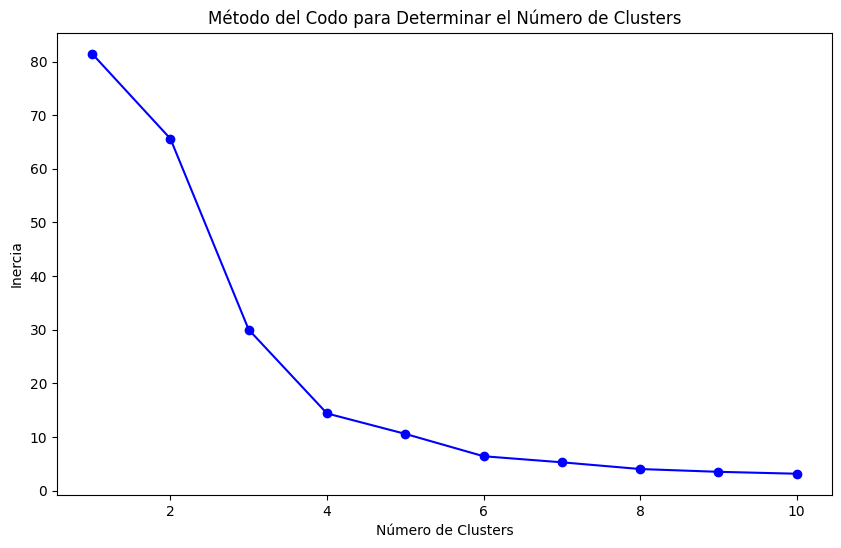

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número de Clusters')
plt.show()

In [6]:
# Definir el número de clusters
num_clusters = 4

# Inicializar y ajustar el modelo KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(pca_df)

# Obtener los labels del clustering
labels = kmeans.labels_


In [7]:
labels[:100]

array([1, 1, 2, 0, 1, 1, 1, 0, 1, 3, 0, 1, 3, 0, 1, 3, 1, 0, 1, 3, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3,
       2, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

Con el coeficiente de siluta medimos qué tan similaresson los puntos a su propio cluster en comparación con otros clústeres.

Un valor mas alto indica que los puntos están mejor agrupados

In [8]:
# Calcular el puntaje de Silhouette
silhouette_avg = silhouette_score(pca_df, labels)
print(f'Puntaje de Silhouette: {silhouette_avg}')

# Añadir los labels al DataFrame
pca_df['Cluster'] = labels


Puntaje de Silhouette: 0.5830729671359918


De acuerdo al valor de nuestro silhouette_score tenemos clústeres aceptables pero podrían mejorarse, dado que los valores van de -1 a 1

In [9]:
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
    score = silhouette_score(pca_df, kmeans.labels_)
    silhouette_scores.append(score)
    print(f'Número de clusters: {k}, Coeficiente de silueta: {score}')

Número de clusters: 2, Coeficiente de silueta: 0.5534333838447387
Número de clusters: 3, Coeficiente de silueta: 0.8010634600472342
Número de clusters: 4, Coeficiente de silueta: 0.8772648732917078
Número de clusters: 5, Coeficiente de silueta: 0.6611352342528529
Número de clusters: 6, Coeficiente de silueta: 0.6055803718242135
Número de clusters: 7, Coeficiente de silueta: 0.5920492629684769
Número de clusters: 8, Coeficiente de silueta: 0.4753863133246488
Número de clusters: 9, Coeficiente de silueta: 0.4350268236917874
Número de clusters: 10, Coeficiente de silueta: 0.4112049563346972


In [10]:
pca_df.head(10)

,PC1,PC2,PC3,Cluster
0,-0.030563,-0.083572,-0.052830,1
1,-0.047028,-0.080536,-0.045201,1
2,0.911343,0.114725,-0.074548,2
3,0.014416,-0.194908,0.347011,0
4,-0.053558,-0.109568,-0.055748,1
5,-0.056335,-0.043727,-0.035107,1
6,-0.064881,-0.107856,-0.337741,1
7,0.022161,-0.185995,0.253974,0
8,-0.017728,-0.074653,-0.081949,1
9,-0.116468,0.308976,0.033719,3


In [11]:
pca_df.shape

(986, 4)

## Implementación de BERT para la Clasificación Semántica

In [12]:
# Cargar el modelo y el tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [13]:
# Función para obtener embeddings de BERT
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        mean_pooling = torch.mean(last_hidden_states, 1).squeeze().numpy()
        embeddings.append(mean_pooling)
    return np.array(embeddings)

In [14]:

# Función para obtener embeddings de BERT
def get_bert_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().numpy()

In [15]:
tfidf_df.head()

,ability,able,academic,access,accurate,achieve,across,active,activities,activity,...,workshop,workshops,world,worthy,would,year,years,yet,young,youth
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.018414,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.088688,0.000000,0.0,...,0.0,0.0,0.0,0.025105,0.087981,0.0,0.0,0.0,0.092155,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.043754,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.016141,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.058718,0.0,0.000000,0.041358,0.0,...,0.0,0.0,0.0,0.016349,0.000000,0.0,0.0,0.0,0.000000,0.0


In [16]:
# Obtener embeddings para cada abstract
#abstracts = tfidf_df['CleanAbstract'].tolist()
abstracts = tfidf_df.columns.tolist()
embeddings = np.vstack([get_bert_embeddings(abstract, tokenizer, model) for abstract in abstracts])

In [17]:
embeddings

array([[ 0.18878575, -0.21629304, -0.04697762, ...,  0.0753741 ,
        -0.3534168 , -0.1438305 ],
       [ 0.12177589, -0.16232471, -0.01973806, ...,  0.06133221,
        -0.15690745, -0.04641017],
       [ 0.09642681,  0.1867423 , -0.49600992, ...,  0.06242619,
        -0.12547325, -0.15790963],
       ...,
       [ 0.3722941 , -0.0874446 , -0.16961034, ..., -0.03049376,
        -0.13727123, -0.1110248 ],
       [-0.07113538,  0.10269932, -0.13215627, ...,  0.17823122,
        -0.19328322, -0.2435456 ],
       [-0.1078673 ,  0.26156023, -0.13756388, ..., -0.2506585 ,
        -0.5075259 , -0.26978615]], dtype=float32)

In [18]:
# Convertir los embeddings en un DataFrame
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv('../data/processed/bert_embeddings.csv', index=False)

In [54]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,Cluster
0,0.188786,-0.216293,-0.046978,0.068493,0.134043,-0.349298,0.258583,-0.129357,0.214276,-0.439769,...,0.039990,0.064393,-0.165182,-0.130374,-0.554999,0.068580,0.075374,-0.353417,-0.143831,1
1,0.121776,-0.162325,-0.019738,0.196310,0.024335,-0.313293,0.367223,-0.247296,0.321522,-0.499578,...,0.004952,-0.137108,-0.262365,-0.112627,-0.500115,0.123297,0.061332,-0.156907,-0.046410,1
2,0.096427,0.186742,-0.496010,-0.032524,-0.283293,-0.153345,0.380802,0.062816,-0.068641,-0.234401,...,-0.264455,0.080784,-0.195659,0.057085,-0.337542,-0.052469,0.062426,-0.125473,-0.157910,3
3,-0.100790,0.029467,-0.150347,-0.041686,0.204167,-0.318282,0.503633,0.198149,-0.127170,-0.326180,...,-0.208686,0.139122,-0.281536,-0.062727,-0.328130,0.087974,0.007795,-0.522465,0.092864,2
4,0.110217,0.013148,0.090255,0.027966,0.031639,-0.183116,0.165058,0.025036,0.186377,-0.157664,...,-0.043671,0.039695,-0.226823,0.029545,-0.539240,0.048452,0.070907,-0.008425,0.077493,2


## Entrenamiento de Clustering con Embeddings de BERT

# Cargar los embeddings de BERT
embeddings_df = pd.read_csv('../data/processed/bert_embeddings.csv')

# Entrenar el modelo de clustering con los embeddings de BERT
kmeans_bert = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_bert.fit(embeddings_df)

# Obtener los labels del clustering
labels_bert = kmeans_bert.labels_
print(labels_bert[:100])

# Calcular el puntaje de Silhouette
silhouette_avg_bert = silhouette_score(embeddings_df, labels_bert)
print(f'Puntaje de Silhouette con BERT: {silhouette_avg_bert}')

# Añadir los labels al DataFrame de embeddings
embeddings_df['Cluster'] = labels_bert


## Visualización de Clusters con Embeddings de BERT

# Reducir la dimensionalidad de los embeddings de BERT a 3 componentes con PCA
pca_bert = PCA(n_components=3)
pca_result_bert = pca_bert.fit_transform(embeddings_df.drop('Cluster', axis=1))

# Crear un DataFrame con los resultados de PCA
pca_bert_df = pd.DataFrame(pca_result_bert, columns=['PC1', 'PC2', 'PC3'])
pca_bert_df['Cluster'] = labels_bert

# Visualizar los clusters en 3D
fig_bert = px.scatter_3d(pca_bert_df, x='PC1', y='PC2', z='PC3', color='Cluster', title='Clusters con BERT en 3D')
fig_bert.show()


In [20]:
pca_df.head()

,PC1,PC2,PC3,Cluster
0,-0.030563,-0.083572,-0.052830,1
1,-0.047028,-0.080536,-0.045201,1
2,0.911343,0.114725,-0.074548,2
3,0.014416,-0.194908,0.347011,0
4,-0.053558,-0.109568,-0.055748,1


In [21]:
pca_df.shape

(986, 4)

In [24]:
pca = PCA(n_components=3)
pca.fit(tfidf_df)

PCA(n_components=3)

In [50]:
original_with_cluster = pca.inverse_transform(pca_df[['PC1', 'PC2', 'PC3']])

In [51]:
original_with_cluster.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.006827,0.002102,0.007715,0.011115,0.003518,0.007052,0.009373,0.005958,0.015635,0.007513,...,0.009423,0.006887,0.004509,0.018823,0.006560,0.001320,0.007238,0.004301,0.005376,0.004921
1,0.006916,0.002317,0.007546,0.010980,0.003561,0.006990,0.009905,0.005942,0.015609,0.007572,...,0.009534,0.006908,0.004608,0.018371,0.006619,0.001653,0.007611,0.004361,0.005474,0.004958
2,-0.000416,-0.000101,0.001251,0.000545,-0.000255,-0.000141,-0.000037,0.003508,-0.000161,-0.000586,...,0.002994,0.000524,0.000288,0.044638,0.000573,0.002014,-0.000961,-0.000618,-0.000060,0.000202
3,0.001950,0.000532,-0.004275,-0.004749,0.002540,0.002131,0.001767,0.006716,0.001076,0.002032,...,0.013641,0.000717,0.005017,0.019474,0.006899,-0.002063,0.012188,0.003539,0.007602,-0.002497
4,0.006927,0.001652,0.008156,0.011613,0.003639,0.007534,0.008395,0.006202,0.016273,0.007732,...,0.009755,0.007051,0.004573,0.018173,0.006845,0.000294,0.007053,0.004468,0.005597,0.004882


In [52]:
tfidf_data_with_cluster_df = original_with_cluster.copy()
tfidf_data_with_cluster_df.columns = tfidf_df.columns

In [53]:
tfidf_data_with_cluster_df.head()

,ability,able,academic,access,accurate,achieve,across,active,activities,activity,...,workshop,workshops,world,worthy,would,year,years,yet,young,youth
0,0.006827,0.002102,0.007715,0.011115,0.003518,0.007052,0.009373,0.005958,0.015635,0.007513,...,0.009423,0.006887,0.004509,0.018823,0.006560,0.001320,0.007238,0.004301,0.005376,0.004921
1,0.006916,0.002317,0.007546,0.010980,0.003561,0.006990,0.009905,0.005942,0.015609,0.007572,...,0.009534,0.006908,0.004608,0.018371,0.006619,0.001653,0.007611,0.004361,0.005474,0.004958
2,-0.000416,-0.000101,0.001251,0.000545,-0.000255,-0.000141,-0.000037,0.003508,-0.000161,-0.000586,...,0.002994,0.000524,0.000288,0.044638,0.000573,0.002014,-0.000961,-0.000618,-0.000060,0.000202
3,0.001950,0.000532,-0.004275,-0.004749,0.002540,0.002131,0.001767,0.006716,0.001076,0.002032,...,0.013641,0.000717,0.005017,0.019474,0.006899,-0.002063,0.012188,0.003539,0.007602,-0.002497
4,0.006927,0.001652,0.008156,0.011613,0.003639,0.007534,0.008395,0.006202,0.016273,0.007732,...,0.009755,0.007051,0.004573,0.018173,0.006845,0.000294,0.007053,0.004468,0.005597,0.004882


In [40]:
data = pd.read_csv('../data/processed/data_awards.csv')
data = data.dropna()
data.shape


(986, 7)

In [42]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['AbstractNarration'])

In [43]:
original_with_cluster = tfidf_vectorizer.inverse_transform(tfidf_matrix)

In [49]:
original_with_cluster_obj = original_with_cluster.copy()
original_with_cluster_obj = pd.DataFrame(original_with_cluster_obj)
original_with_cluster_obj.head()

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,209,210,211,212,213
0,project,funded,program,division,chemistry,professor,university,building,sustainable,polymers,...,None,None,None,None,None,None,None,None,None,None
1,chemistry,research,broader,development,br,new,groups,various,chemical,award,...,None,None,None,None,None,None,None,None,None,None
2,project,program,university,research,broader,training,br,new,award,reflects,...,None,None,None,None,None,None,None,None,None,None
3,project,research,defined,structure,broader,training,opportunities,students,br,new,...,None,None,None,None,None,None,None,None,None,None
4,project,program,division,chemistry,university,building,polymers,large,research,light,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
original_with_cluster_obj['Cluster'] = pca_df['Cluster']

## Guardar el Modelo y Resultados

Se guarda el modelo entrendo y los resultados del clustering del mejor modelo:

In [55]:
import joblib

# Guardar el modelo KMeans entrenado
joblib.dump(kmeans, '../models/kmeans.pkl')

# Guardar el DataFrame de embeddings con clusters
# embeddings_df.to_csv('../data/processed/bert_embeddings_with_clusters.csv', index=False)

['../models/kmeans.pkl']

In [57]:
pca_df.to_csv('../data/outputs/pca_df.csv', index=False)

## Conclusiones

- Se entrenó un modelo de clustering KMeans para agrupar los datos.
- Se utilizó BERT para obtener embeddings semánticos de los textos ( el resultado fue peor a un modelo discriminatorio)
- Se realizó clustering con los embeddings de BERT y se visualizó los resultados.

## Próximos pasos

1. Evaluar la calidad de los clusters y ajustar el modelo según sea necesario.
2. Desarrollar un sistema de recomendación basado en los clusters.
3. Implementar un pipeline de inferencia para clasificar nuevos documentos.